## Simulation Study
Conduct fast-forwarding simulation study with different schedulers.

In [1]:
# imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from src.afm_sim import AFMSim
from src.bkt_inference import BKTInference
from src.sim_step_logger import SimStepLogger
from src.random_scheduler import RandomScheduler
from src.determinstic_scheduler import DeterministicScheduler
from src.mastery_easy import MasteryEasyScheduler
from src.mastery_hard import MasteryHardScheduler
from src.focus_det_kc import FocusDetScheduler
from src.focus_rnd_kc import FocusRndScheduler
from src.focus_practice_cb import FocusedPracticeScheduler
from src.util import set_random_seeds

#### Helper functions

In [2]:
def init_p_log(inference):
    """Prepare p_log to reflect initial student mastery.
    
    Args:
        inference: knowledge inference object (e.g., BKTInference)

    Returns:
        p_log (dict): log for problem practice
    """
    p_log = {
        "p_id": "INIT",
        "step": [],
        "corrects": [],
        "masteries": inference.get_state()
    }
    return p_log

def simulate_step(simulator, inference, p_id, step):
    """Simulate student practicing one problem.
    
    Args:
        simulator: student simulator object (e.g., AFMSim)
        inference: knowledge inference object (e.g., BKTInference)
        p_id (str): identifier for current practice problem
        step (list): list with KCs for one step
    
    Returns:
        p_log (dict): log for step practice
    """
    _, cor = simulator.simulate_response(step)
    cors = [cor for _ in step]
    simulator.update_state(step, cors)
    inference.update_state(step, cors)
    masteries = inference.get_state()
    p_log = {"p_id": p_id, "step": step, "corrects": cors,
             "masteries": masteries}
    return p_log, masteries

def init_scheduler(name, problem_path):
    """Initializes new scheduler object.mro
    
    Args:
        name (str): specifies type of scheduler
        problem_path (str): specifies problem pool for scheduler
    """
    if name == "random":
        return RandomScheduler(problem_path=problem_path)
    elif name == "deterministic":
        return DeterministicScheduler(problem_path=problem_path)
    elif name == "mastery_easy":
        return MasteryEasyScheduler(problem_path=problem_path)
    elif name == "mastery_hard":
        return MasteryHardScheduler(problem_path=problem_path)
    elif name == "focus_det":
        return FocusDetScheduler(problem_path=problem_path)
    elif name == "focus_rnd":
        return FocusRndScheduler(problem_path=problem_path)
    elif name == "focus_practice_cb":
        return FocusedPracticeScheduler(problem_path=problem_path)
    else:
        raise ValueError("Unknown scheduler:" + name)

In [3]:
def get_overpract(kc, cors, bkt_paras):
    """Compute number of overpractice opportunities."""
    bkt_inf = BKTInference(para_path=bkt_paras)
    preds = bkt_inf.manual_bkt(kc, cors)

    # determine overpractice
    for idx in range(1, len(preds) + 1):
        mastery = preds[-idx]
        if mastery < MASTER_THRESH:  # most recent below
            break
    over = max(0, (idx - 2))
    return over


def get_underpract(kc, cors, bkt_paras):
    """Compute number of underpractice opportunities."""
    bkt_inf = BKTInference(para_path=bkt_paras)
    preds = bkt_inf.manual_bkt(kc, cors)
    #print(preds)
    
    # determine overpractice
    for idx in range(1, len(preds) + 1):
        mastery = preds[-idx]
        if mastery < MASTER_THRESH:  # most recent below
            break

    # determine underpractice
    under = 0
    if idx == 1:  # detected underpractice
        #print('HELLLLLO')
        mastery = preds[-idx]
        p_learn = bkt_inf.paras[kc]["p_learn"]
        while mastery < MASTER_THRESH:  # expected steps till mastery
            mastery = mastery + ((1 - mastery) * p_learn)
            under += 1
    return under


def get_over_underpractice(logger, bkt_paras):
    """Computer over- and under-practice statistics."""
    oppos = logger.get_kc_opportunity()
    
    over_dicts, under_dicts = [], []
    for student in oppos:
        over_dicts.append({k: get_overpract(k, entry["correct"], bkt_paras)
                           for k, entry in student.items()})    
        under_dicts.append({k: get_underpract(k, entry["correct"], bkt_paras)
                            for k, entry in student.items()})    

    combined_over_dict = {key: [] for key in over_dicts[0].keys()}
    combined_under_dict = {key: [] for key in under_dicts[0].keys()}

    for d in over_dicts:
        for key, value in d.items():
            combined_over_dict[key].append(value)
    for d in under_dicts:
        for key, value in d.items():
            combined_under_dict[key].append(value)
    
    over_mean_dict = \
        {key: np.mean(values) for key, values in combined_over_dict.items()}
    over_std_dict = \
        {key: np.std(values) for key, values in combined_over_dict.items()}
    over_ci_dict = \
        {key: f'[{np.quantile(values, 0.025)}, {np.quantile(values, 0.975)}]' for key, values in combined_over_dict.items()}
    under_ci_dict = \
        {key: f'[{np.quantile(values, 0.025)}, {np.quantile(values, 0.975)}]' for key, values in combined_under_dict.items()}
    
    under_mean_dict = \
        {key: np.mean(values) for key, values in combined_under_dict.items()}
    under_std_dict = \
        {key: np.std(values) for key, values in combined_under_dict.items()}
    sim_count_dict = \
        {key: len(values) for key, values in combined_under_dict.items()}

    return over_mean_dict, over_std_dict, under_mean_dict, under_std_dict, sim_count_dict, over_ci_dict, under_ci_dict


def simulate_student(scheduler, problem_path, afm_sim, bkt_inf, logger,
                     cut_early=False, limit_type="NONE", limit_n=50, replenish_problems_when_empty=False):
    """Run simulation for a single student"""
    #print('NEW STUDENT')
    assert limit_type in ["NONE", "PROBLEMS", "STEPS", "OPPORTUNITY"]
    scheduler = init_scheduler(scheduler, problem_path)
    afm_sim.reset_state()
    bkt_inf.reset_state()
    logger.to_buffer(init_p_log(bkt_inf))

    # simulation loop
    not_master = ["DUMMY"]
    n_problems, n_steps, n_opps = 0, 0, 0  # for stopping criteria
    while True:
        # outer loop
        n_problems += 1
        if (limit_type == "PROBLEMS") and (n_problems > limit_n):
            logger.save_buffer()
            return

        p_id, steps = scheduler.select_problem(bkt_inf.get_state())
        if p_id == -1:  # scheduler returns -1 when problem pool is exhausted
            if not replenish_problems_when_empty:
                break
            else:
                n_problems -= 1
                scheduler.problem_pool.replenish_pool()
                continue

        # inner loop
        for i, _ in enumerate(steps):
            if (i > 0) and cut_early:  # NOTE: Cut-early strategy
                knows_all = True
                state = masteries
                for j in range(i, len(steps)):
                    if not np.all([state[k] >= MASTER_THRESH for k in steps[j]]):
                        knows_all = False
                if knows_all:
                    break

            n_steps += 1
            if (limit_type == "STEPS") and (n_steps > limit_n):
                logger.save_buffer()
                return
            
            # simulate step and cut
            p_log, masteries = simulate_step(afm_sim, bkt_inf, p_id, steps[i])
            n_opps += len(steps[i])
            if (limit_type == "OPPORTUNITY") and (n_opps > limit_n):
                logger.save_buffer()
                return

            not_master = [k for k in masteries if masteries[k] < MASTER_THRESH]
            logger.to_buffer(p_log)

        # NOTE: Stopping conditions
        ## break if everything is mastered
        #print(len(not_master))
        if len(not_master) == 0:
            #print('ALL MASTERED')
            break
        ## break if all unmastered KCs have no content
        available = [scheduler.problem_pool.check_skill_available(kc) for kc in not_master]
        if not np.any(available):
            if not replenish_problems_when_empty:
                break
            else:
                scheduler.problem_pool.replenish_pool()
                #print(masteries)

    if replenish_problems_when_empty:
        #print(masteries)
        assert np.all([masteries[k] >= MASTER_THRESH for k in masteries]), "not all mastered"
    
    logger.save_buffer()  # save before moving to next student


def run_sim(num_students, scheduler, problem_path, data_path, bkt_paras,
            cut_early=False, limit_type="NONE", limit_n=50, replenish_problems_when_empty=False):
    """Run simulation for number of students and return statistics."""
    # initialize models
    afm_sim = AFMSim(data_path=data_path, fit=False, verb=True)
    bkt_inf = BKTInference(para_path=bkt_paras)

    # run simulation
    logger = SimStepLogger()
    for _ in tqdm(range(num_students)):
        simulate_student(scheduler, problem_path, afm_sim, bkt_inf, logger,
                         cut_early=cut_early, limit_type=limit_type, limit_n=limit_n, 
                        replenish_problems_when_empty=replenish_problems_when_empty)

    over_d_dat, over_d_dat_std, under_d_dat, under_d_dat_std, sim_count_dict, over_ci_dict, under_ci_dict =\
        get_over_underpractice(logger, bkt_paras=bkt_paras)

    # TODO: save std and counts -> conduct t-test and add results to paper
    df_res = pd.melt(pd.DataFrame([over_d_dat]), var_name='kc', value_name='over_practice_diff')
    df_under = pd.melt(pd.DataFrame([under_d_dat]), var_name='kc', value_name='under_practice_diff')

    df_over_std = pd.melt(pd.DataFrame([over_d_dat_std]), var_name='kc', value_name='over_sd')
    df_over_ci = pd.melt(pd.DataFrame([over_ci_dict]), var_name='kc', value_name='over_ci')

    df_res = df_res\
        .merge(df_over_std, how='left', on='kc')\
        .merge(df_over_ci, how='left', on='kc')

    df_res['scheduler'] = scheduler
    df_res['cut_early'] = cut_early
    df_res['n_students'] = num_students
    df_res['afm_params'] = data_path.split('/')[-1].split('.csv')[0].split('_')[-1]
    df_res["under_practice_diff"] = df_under["under_practice_diff"].values
    df_res["replenish"] = replenish_problems_when_empty
    return df_res

## RQ1 -- cut early effect with legacy scheduler

In [4]:
# configuration
MASTER_THRESH = 0.95
NUM_STUDENTS = 10000
# we can terminate based on number of problems/steps/KC opportunities ## 21.5 problems is median (22) # and 38.0 median steps
LIMITER_TYPER = "PROBLEMS" #"OPPORTUNITY"  # "NONE", "PROBLEMS", "STEPS", "OPPORTUNITY"
LIMITER_N = 22
AFM_PARAS = "./data/afm_paras_borchers2024apta.csv"
BKT_PARAS = "./data/bkt_paras_tutorshop.csv"
SOLUTION_PATHS = "./data/common_solution_path.json"
SEED = 0
set_random_seeds(SEED)

In [5]:
# deterministic scheduler: broken assertion, commented out for now: n_steps <= min([len(lo) for lo in self.logs])
dfs = []
# FIXME: 'deterministic' --> and then add back
for scheduler in ['mastery_hard']: #  'focus_det', 'focus_rnd',
    for replenish in [False, True]:
        for cut_early in [True, False]:
            for afm_setting in [AFM_PARAS]:
                print(f'Simulating: {scheduler}, cut: {cut_early} with {afm_setting} and replenish {replenish}')
                df_res = run_sim(NUM_STUDENTS, scheduler,
                       problem_path=SOLUTION_PATHS,
                       data_path=afm_setting,
                       bkt_paras=BKT_PARAS,
                       cut_early=cut_early,
                       limit_type=LIMITER_TYPER, limit_n=LIMITER_N, replenish_problems_when_empty=replenish)
                dfs.append(df_res) 
df_sim_all = pd.concat(dfs)

Simulating: mastery_hard, cut: True with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:10<00:00, 960.85it/s]


Simulating: mastery_hard, cut: False with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:09<00:00, 1044.58it/s]


Simulating: mastery_hard, cut: True with ./data/afm_paras_borchers2024apta.csv and replenish True


100%|██████████| 10000/10000 [00:10<00:00, 978.97it/s]


Simulating: mastery_hard, cut: False with ./data/afm_paras_borchers2024apta.csv and replenish True


100%|██████████| 10000/10000 [00:09<00:00, 1020.06it/s]


In [6]:
# First question: Overall effect on CUT early, without scheduler

a = df_sim_all[(df_sim_all['scheduler']=='mastery_hard') & (df_sim_all['replenish']==False) & (df_sim_all['cut_early']==False)].over_practice_diff.sum()
b = df_sim_all[(df_sim_all['scheduler']=='mastery_hard') & (df_sim_all['replenish']==False) & (df_sim_all['cut_early']==True)].over_practice_diff.sum()

print(f'For the legacy mastery-based problem selector, cut early reduces overpractice by {round((1-(b/a))*100, 2)}\% for the average student.')

For the legacy mastery-based problem selector, cut early reduces overpractice by 35.59\% for the average student.


In [7]:
a = df_sim_all[(df_sim_all['scheduler']=='mastery_hard') & (df_sim_all['replenish']==False) & (df_sim_all['cut_early']==False)].under_practice_diff.sum()
b = df_sim_all[(df_sim_all['scheduler']=='mastery_hard') & (df_sim_all['replenish']==False) & (df_sim_all['cut_early']==True)].under_practice_diff.sum()

print(f'\nHowever, cut early also introduced underpractice, totalling an average of M = {b} ' + \
      f'per student compared to almost no underpractice when cut early was not applied: M = {a}.')


However, cut early also introduced underpractice, totalling an average of M = 0.0 per student compared to almost no underpractice when cut early was not applied: M = 0.0.


In [8]:
b = df_sim_all[(df_sim_all['scheduler']=='mastery_hard') & (df_sim_all['replenish']==True) & (df_sim_all['cut_early']==True)].under_practice_diff.sum()

print(f'\nThis underpractice was mitigated by replenishing to M = {b}.')


This underpractice was mitigated by replenishing to M = 0.0.


In [9]:
df_sim_all2 = df_sim_all.copy()
df_sim_all2['kc'] = df_sim_all2['kc'].map(lambda s: 'simplify-division' if s=='divide' else s)

df_pivot = df_sim_all2.pivot_table(
    index='cut_early', 
    columns='kc', 
    values='over_practice_diff', 
    aggfunc='sum'
)

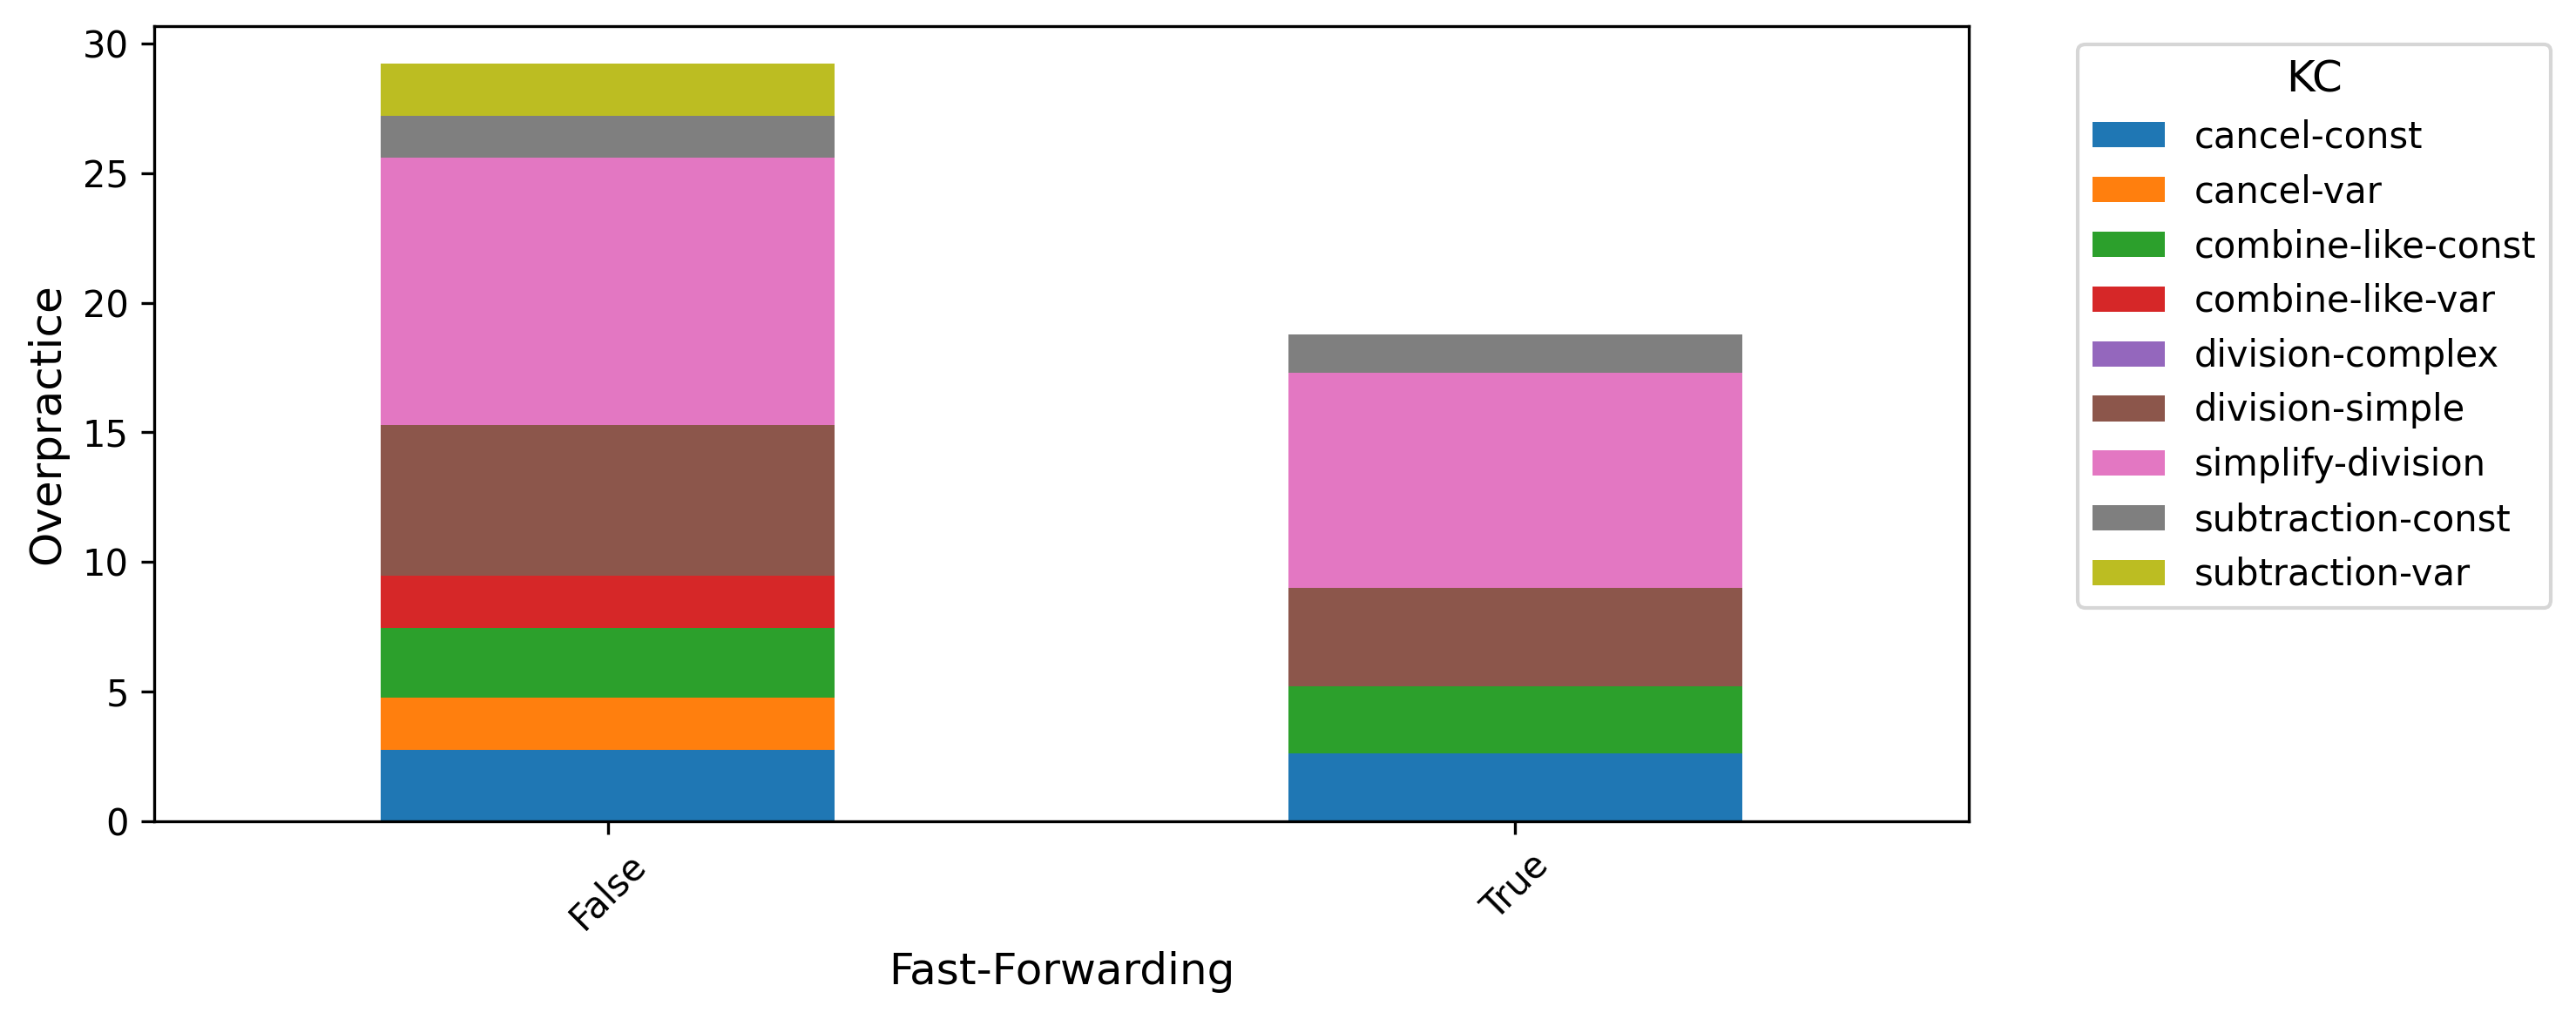

In [10]:
# Increase DPI for higher resolution
plt.figure(figsize=(10, 4), dpi=300)  # Adjust DPI to 300 for high-resolution output

ax = df_pivot.plot(kind='bar', stacked=True, ax=plt.gca())

# Remove the plot title
ax.set_title('')

# Set labels with increased font size for publication
ax.set_xlabel('Fast-Forwarding', fontsize=12)
ax.set_ylabel('Overpractice', fontsize=12)

# Increase the font size of tick labels
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

# Adjust the legend: make it smaller and position it outside the plot
ax.legend(title='KC', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.xticks(rotation=45)  # Adjust rotation if needed for better readability
plt.tight_layout()

# Save the plot as a high-resolution image file
plt.savefig('stacked_bar_plot.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

([0, 1], [Text(0, 0, 'False'), Text(1, 0, 'True')])

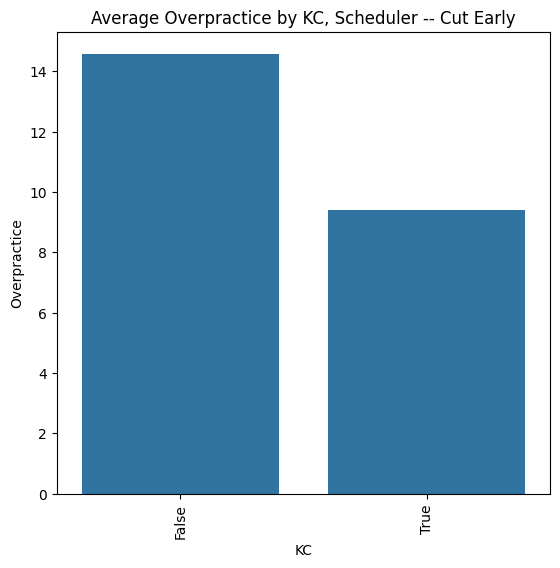

In [11]:
df_grouped1 = df_sim_all[~df_sim_all['replenish']].groupby(['cut_early'])[['over_practice_diff', 'under_practice_diff']].sum().reset_index()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.barplot(x='cut_early', y='over_practice_diff', data=df_grouped1, errorbar=None)
plt.title('Average Overpractice by KC, Scheduler -- Cut Early')
plt.xlabel('KC')
plt.ylabel('Overpractice')
plt.xticks(rotation=90)

### Run simulation RQ2

In [12]:
# configuration
MASTER_THRESH = 0.95
NUM_STUDENTS = 10000
# we can terminate based on number of problems/steps/KC opportunities ## 21.5 problems is median (22) # and 38.0 median steps
LIMITER_TYPER = "NONE" #"OPPORTUNITY"  # "NONE", "PROBLEMS", "STEPS", "OPPORTUNITY"
LIMITER_N = ''  # no limit
AFM_PARAS = "./data/afm_paras_borchers2024apta.csv"
BKT_PARAS = "./data/bkt_paras_tutorshop.csv"
SOLUTION_PATHS = "./data/common_solution_path.json"
SEED = 0
set_random_seeds(SEED)

In [13]:
# deterministic scheduler: broken assertion, commented out for now: n_steps <= min([len(lo) for lo in self.logs])
dfs = []
# FIXME: 'deterministic' --> and then add back
for scheduler in ['random', 'deterministic', 'mastery_easy', 'mastery_hard', 'focus_practice_cb']: #  'focus_det', 'focus_rnd',
    for replenish in [False]:
        for cut_early in [False, True]:
            for afm_setting in [AFM_PARAS]:
                print(f'Simulating: {scheduler}, cut: {cut_early} with {afm_setting} and replenish {replenish}')
                df_res = run_sim(NUM_STUDENTS, scheduler,
                       problem_path=SOLUTION_PATHS,
                       data_path=afm_setting,
                       bkt_paras=BKT_PARAS,
                       cut_early=cut_early,
                       limit_type=LIMITER_TYPER, limit_n=LIMITER_N, replenish_problems_when_empty=replenish)
                dfs.append(df_res) 
df_sim_all = pd.concat(dfs)

Simulating: random, cut: False with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:08<00:00, 1209.36it/s]


Simulating: random, cut: True with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:07<00:00, 1298.98it/s]


Simulating: deterministic, cut: False with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:34<00:00, 288.90it/s]


Simulating: deterministic, cut: True with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:31<00:00, 314.99it/s]


Simulating: mastery_easy, cut: False with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:14<00:00, 693.06it/s]


Simulating: mastery_easy, cut: True with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:15<00:00, 658.73it/s]


Simulating: mastery_hard, cut: False with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:09<00:00, 1018.46it/s]


Simulating: mastery_hard, cut: True with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:10<00:00, 976.14it/s]


Simulating: focus_practice_cb, cut: False with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:18<00:00, 545.43it/s]


Simulating: focus_practice_cb, cut: True with ./data/afm_paras_borchers2024apta.csv and replenish False


100%|██████████| 10000/10000 [00:18<00:00, 541.76it/s]


In [14]:
df_sim_all['yerr_lower'] = df_sim_all['over_ci'].map(lambda s: float(s.split(',')[0].split('[')[-1]))
df_sim_all['yerr_upper'] = df_sim_all['over_ci'].map(lambda s: float(s.split(',')[-1].split(']')[0]))

df_grouped_final = df_sim_all.groupby(['scheduler', 'cut_early']).agg({
    'over_practice_diff': 'sum',  # Mean over_practice_diff
    'over_sd': lambda x: np.sqrt(np.sum((x**2) * (len(x) - 1)) / np.sum(len(x) - 1)),  # Pooled SD
    'yerr_lower': 'sum',  # Assuming mean is appropriate for yerr
    'yerr_upper': 'sum'   # Assuming mean is appropriate for yerr
}).reset_index()

In [15]:
# Assuming df_grouped_final contains the provided data
df_scheduler = df_grouped_final.copy()

# Mapping for more descriptive scheduler names
scheduler_mapping = {
    'deterministic': 'Deterministic',
    'focus_practice_cb': 'Focus Practice',
    'mastery_easy': 'Mastery Easy',
    'mastery_hard': 'Mastery Hard',
    'random': 'Random'
}
df_scheduler['scheduler2'] = df_scheduler['scheduler'].map(scheduler_mapping)

# Calculate the percentage reduction for each scheduler
percentage_reduction = []
for scheduler in df_scheduler['scheduler'].unique():
    df_sub = df_scheduler[df_scheduler['scheduler'] == scheduler]
    over_practice_false = df_sub[df_sub['cut_early'] == False]['over_practice_diff'].values[0]
    over_practice_true = df_sub[df_sub['cut_early'] == True]['over_practice_diff'].values[0]

    over_practice_sd_false = df_sub[df_sub['cut_early'] == False]['over_sd'].values[0]
    over_practice_sd_true = df_sub[df_sub['cut_early'] == True]['over_sd'].values[0]
    
    # Compute the percentage reduction
    reduction = ((over_practice_false - over_practice_true) / over_practice_false) * 100
    d = ((over_practice_false - over_practice_true) / ((over_practice_sd_false+over_practice_sd_true)/2))
    percentage_reduction.append((scheduler, reduction, d))
percentage_reduction # with cohen's d

[('deterministic',
  np.float64(8.451943681567702),
  np.float64(8.884962171644553)),
 ('focus_practice_cb',
  np.float64(7.872078720787217),
  np.float64(0.409933616936982)),
 ('mastery_easy',
  np.float64(0.09419763611295777),
  np.float64(0.04348062422608909)),
 ('mastery_hard',
  np.float64(35.711835334476845),
  np.float64(3.3855412898548476)),
 ('random', np.float64(13.950389655087637), np.float64(0.6666090264668907))]

In [16]:
# Assuming df_grouped_final contains the provided data
df_scheduler = df_grouped_final.copy()

# Mapping for more descriptive scheduler names
scheduler_mapping = {
    'deterministic': 'Deterministic',
    'focus_practice_cb': 'Focus Practice',
    'mastery_easy': 'Mastery Easy',
    'mastery_hard': 'Mastery Hard',
    'random': 'Random'
}
df_scheduler['scheduler2'] = df_scheduler['scheduler'].map(scheduler_mapping)

# Calculate the percentage reduction for each scheduler
percentage_reduction = []
for scheduler in df_scheduler['scheduler'].unique():
    df_sub = df_scheduler[df_scheduler['scheduler'] == scheduler]
    over_practice_false = df_sub[df_sub['cut_early'] == False]['over_practice_diff'].values[0]
    over_practice_true = df_sub[df_sub['cut_early'] == True]['over_practice_diff'].values[0]

    over_practice_sd_false = df_sub[df_sub['cut_early'] == False]['over_sd'].values[0]
    over_practice_sd_true = df_sub[df_sub['cut_early'] == True]['over_sd'].values[0]
    
    # Compute the percentage reduction
    reduction = ((over_practice_false - over_practice_true) / over_practice_false) * 100
    d = ((over_practice_false - over_practice_true) / ((over_practice_sd_false+over_practice_sd_true)/2))
    percentage_reduction.append((scheduler, reduction))

/var/folders/99/mgtg9zls1k37b9ngk9bkwqmh0000gn/T/ipykernel_34416/841555830.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


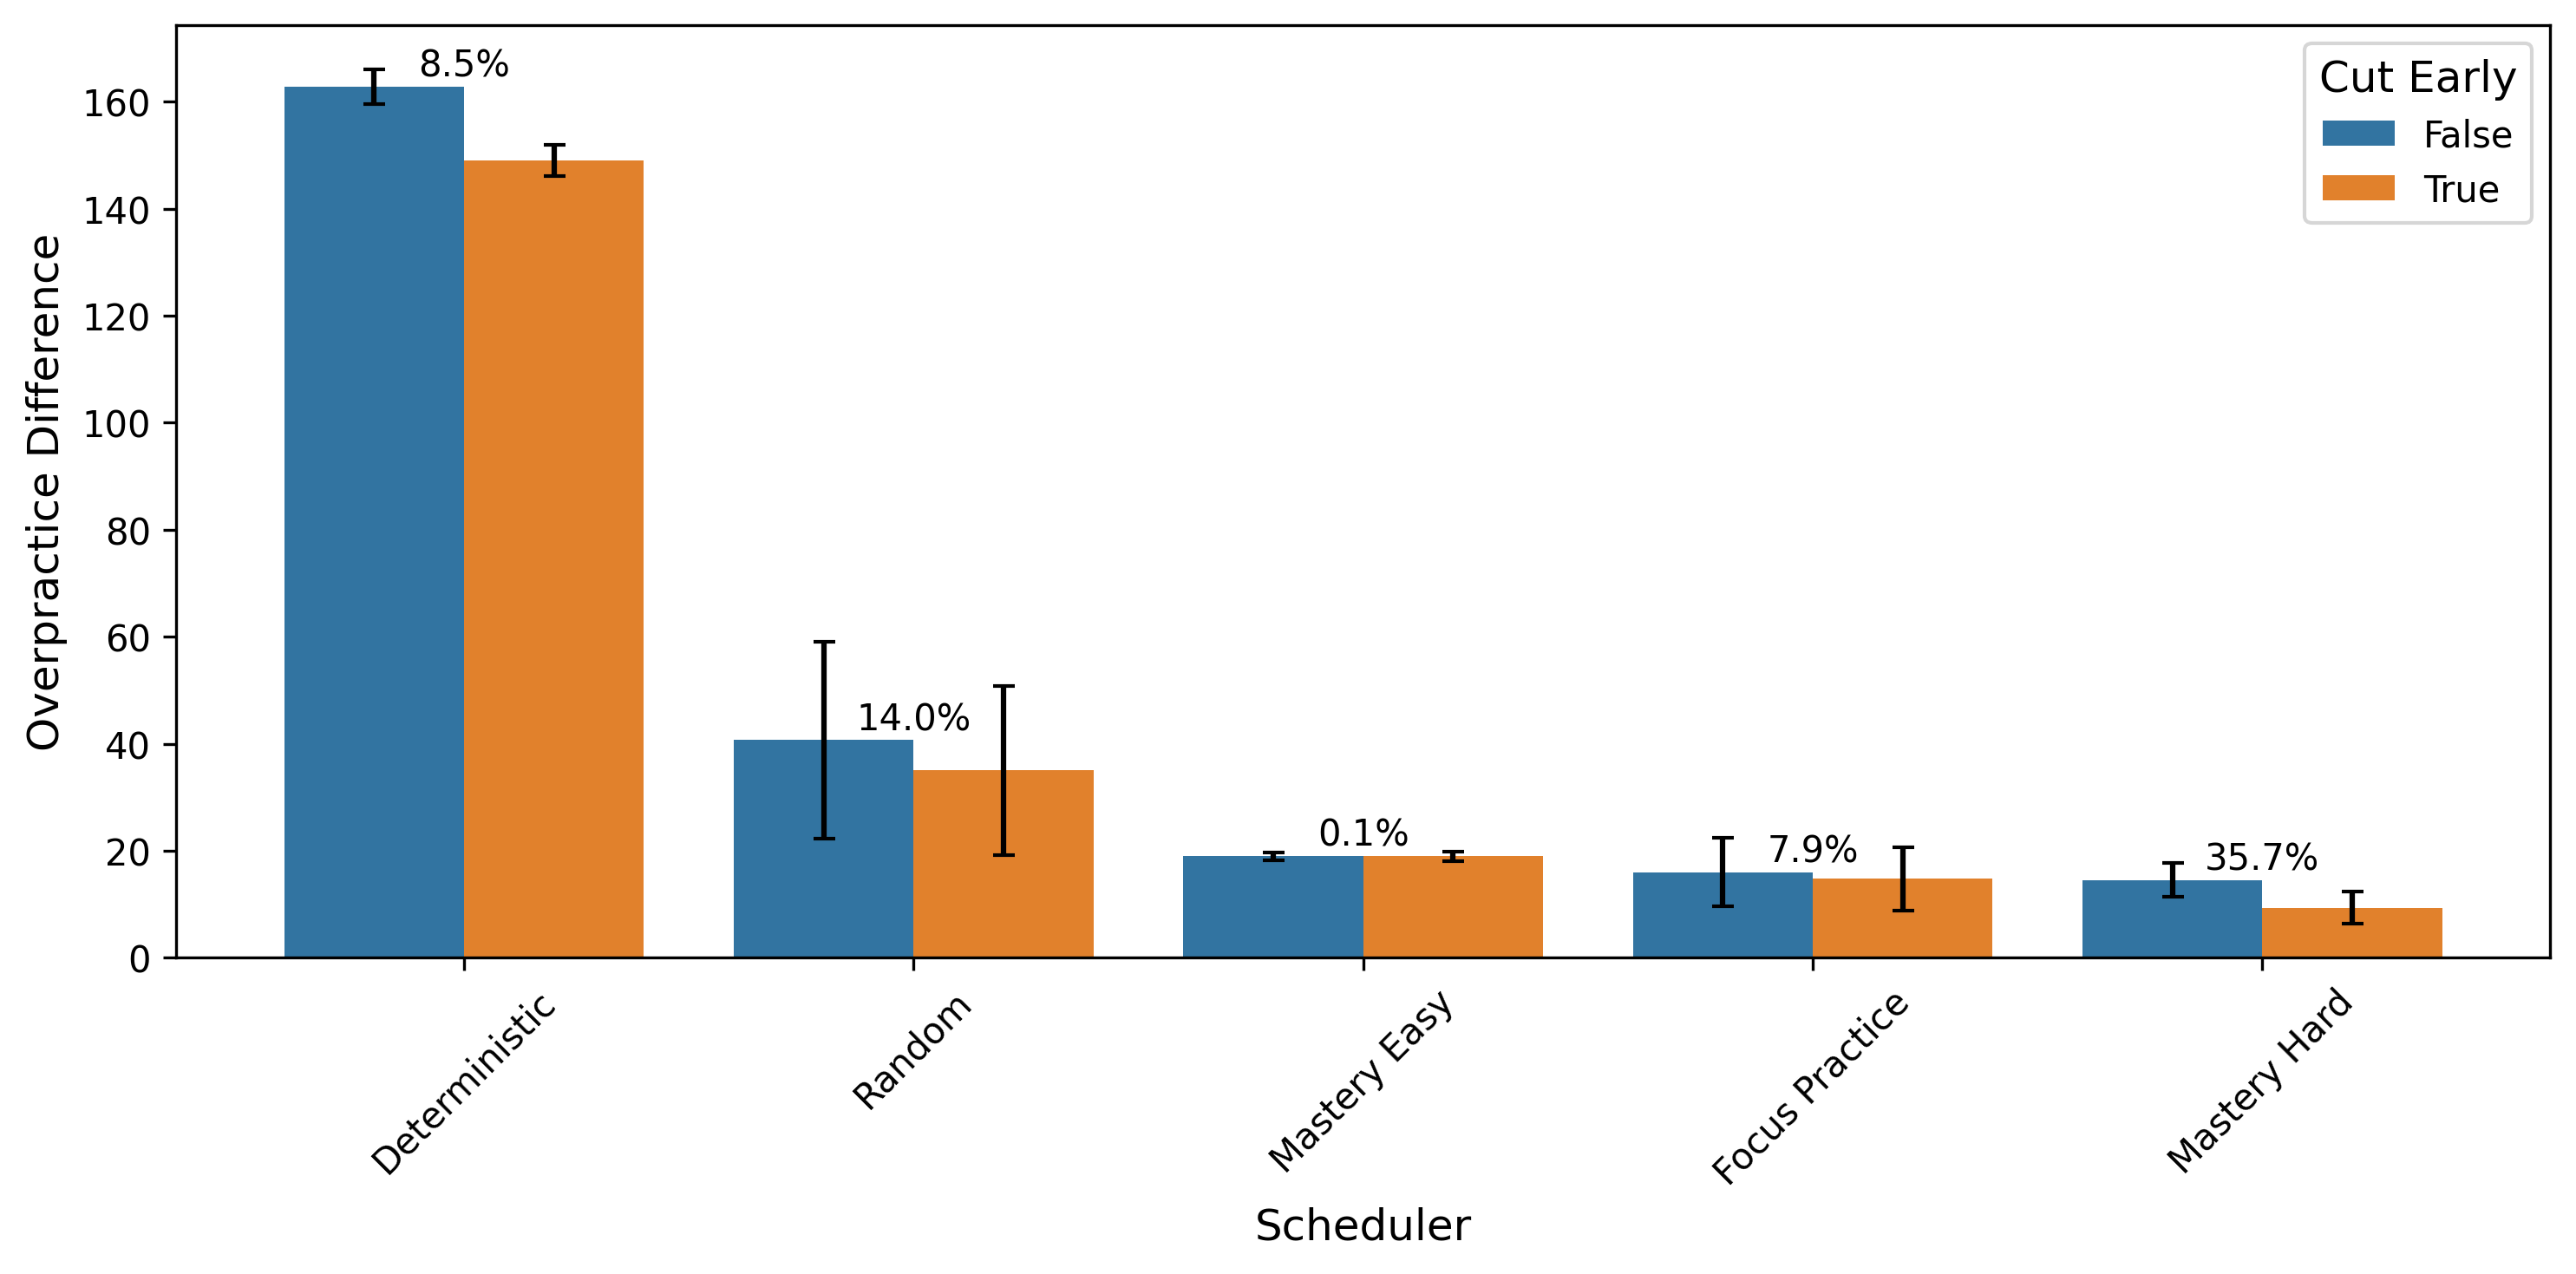

In [17]:
# Convert to DataFrame for easier annotation
df_reduction = pd.DataFrame(percentage_reduction, columns=['scheduler', 'percent_reduction'])
df_scheduler = df_scheduler.merge(df_reduction, on='scheduler')

# Sort the data by 'over_practice_diff' in descending order
df_scheduler_sorted = df_scheduler.sort_values(by='over_practice_diff', ascending=False)

plt.figure(figsize=(10, 5), dpi=300)

# Create the bar plot
ax = sns.barplot(
    x='scheduler2',
    y='over_practice_diff',
    hue='cut_early',
    data=df_scheduler_sorted,
    ci=None  # Disable automatic confidence intervals
)

# Add manual error bars per (scheduler2, cut_early) pair
for i, row in df_scheduler_sorted.iterrows():
    # Find x-position based on the combination of scheduler2 and hue
    xpos = list(df_scheduler_sorted['scheduler2'].unique()).index(row['scheduler2'])
    
    # Adjust x position slightly for hue groups
    if row['cut_early'] == False:
        xpos -= 0.2  # Shift left for False
    else:
        xpos += 0.2  # Shift right for True

    lower_diff = round(row['over_practice_diff']-row['yerr_lower'])
    upper_diff = round(row['yerr_upper']-row['over_practice_diff'])
    plt.errorbar(
        x=xpos,  
        y=row['over_practice_diff'],  
        yerr=2*row['over_sd'], 
        fmt='none',  
        capsize=3,   
        color='black' 
    )

# Annotate with percentage reductions
for scheduler in df_scheduler['scheduler'].unique():
    # Subset the sorted data to get the max y value for each scheduler
    scheduler_name = scheduler_mapping[scheduler]
    max_y_value = df_scheduler_sorted[df_scheduler_sorted['scheduler'] == scheduler]['over_practice_diff'].max()
    
    # Find the x position for the scheduler
    xpos = list(df_scheduler_sorted['scheduler2'].unique()).index(scheduler_name)
    
    # Get the percentage reduction
    reduction = df_reduction[df_reduction['scheduler'] == scheduler]['percent_reduction'].values[0]
    reduction = df_reduction[df_reduction['scheduler'] == scheduler]['percent_reduction'].values[0]
    
    # Annotate slightly above the maximum y value for this scheduler
    ax.text(xpos, max_y_value + 2,  # y position slightly above the max y value
            f"{reduction:.1f}%", 
            color='black', ha="center", fontsize=10)

# Adjust labels
plt.xlabel('Scheduler', fontsize=12)
plt.ylabel('Overpractice Difference', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Adjust the legend
plt.legend(title='Cut Early', loc='upper right', fontsize=10, title_fontsize=12)

# Tight layout for better spacing
plt.tight_layout()

# Save the plot
plt.savefig('scheduler_overpractice.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()